In [59]:
from imp import reload
import cProfile

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import cca
import synth_data

reload(cca)
reload(synth_data)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

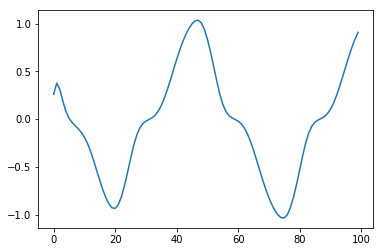

(9800, 10)


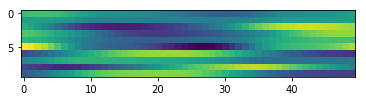

In [74]:
#Make Kernel
#K = synth_data.gen_gp_kernel("squared_exp", spatial_scale=0.5, temporal_scale=5.0)
T_pi = 5

#Generate data
#T = 500
#num_to_concat = 10

N = 50
T = 100 #5000
integration_dt = 0.001
data_dt = 0.01
noise_cov = np.eye(N)*0
#X = synth_data.embed_lorenz_system(T, integration_dt, data_dt, N, noise_cov)
X = synth_data.gen_chaotic_rnn(N, T, integration_dt, data_dt, noise_cov=noise_cov)

N = 10
X = X[:, :N]

plt.plot(X[:100, 0])
plt.show()

X = X[100:-100]
print(X.shape)

#Dimension of ambient space
#N = 10

#Dimension of ambient space GP embedding
#d = 3

#Noise covariance
#noise_dim = 1e10
#noise_variance = 1
#noise_spectrum = noise_variance*np.exp(-np.arange(N)/(noise_dim/2))
#noise_V = scipy.stats.ortho_group.rvs(N)
#noise_cov = np.dot(noise_V, np.dot(np.diag(noise_spectrum), noise_V.T))

#Generate data 
#X, E, full_pi, embedding_pi = synth_data.embed_gp(T, N, d, K, noise_cov, T_pi, num_to_concat=num_to_concat)

plt.imshow(X[:5*X.shape[1], :].T)
plt.show()

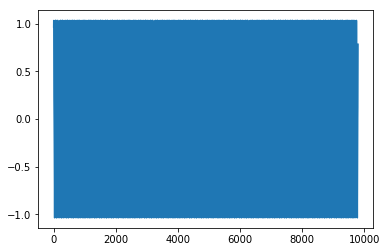

In [75]:
plt.plot(X[:, 0])

In [ ]:
reload(cca)

cross_cov_mats_reg = cca.calc_cross_cov_mats_from_data(X, 2*T_pi, regularization="Abadir", reg_ops={"M":10, "S":50, "skip":T_pi})
cross_cov_mats_no_reg = cca.calc_cross_cov_mats_from_data(X, 2*T_pi, regularization=None)

pi_proj_reg_vals = np.zeros(N+1)
pi_proj_no_reg_vals = np.zeros(N+1)

for opt_dim in range(1, N+1):
    
    V_opt_reg = cca.run_cca(cross_cov_mats_reg, opt_dim, init="random")
    V_opt_no_reg = cca.run_cca(cross_cov_mats_no_reg, opt_dim, init="random")
    
    pi_proj_reg = cca.calc_pi_from_cross_cov_mats(cross_cov_mats_reg, proj=V_opt_reg)
    pi_proj_no_reg = cca.calc_pi_from_cross_cov_mats(cross_cov_mats_no_reg, proj=V_opt_no_reg)
    
    pi_proj_reg_vals[opt_dim] = pi_proj_reg
    pi_proj_no_reg_vals[opt_dim] = pi_proj_no_reg
    
    print(pi_proj_no_reg, pi_proj_reg)
    
    
    

2.0018708912772354e-14
-0.0003317609391203662
0.0
-0.006976449102285965
14.371342245894954 25.608232038113364
23.110198222618788 43.1714006382467
30.969661425159345 57.545747691592716
37.296170817109 70.7716179063798
46.47744603566621 83.50961357257832


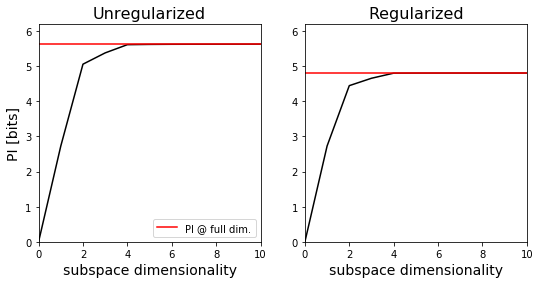

In [35]:
full_pi_reg = np.max(pi_proj_reg_vals)
#embedding_pi_reg = cca.calc_pi_from_cross_cov_mats(cross_cov_mats_reg, proj=E)

full_pi_no_reg = np.max(pi_proj_no_reg_vals)
#embedding_pi_no_reg = cca.calc_pi_from_cross_cov_mats(cross_cov_mats_no_reg, proj=E)

fig, axes = plt.subplots(1, 2, figsize=(8.75, 4))
ax1, ax2 = axes

ax1.plot(np.arange(N+1), pi_proj_no_reg_vals, c="black")
ax1.axhline(full_pi_no_reg, label="PI @ full dim.", c="red")
#ax1.axhline(embedding_pi_no_reg, label="PI @ embedding proj.", c="gray")
#ax1.axvline(d, label="true latent dim.", c="blue")

ax1.set_title("Unregularized", fontsize=16)
ax1.set_xlabel("subspace dimensionality", fontsize=14)
ax1.set_ylabel("PI [bits]", fontsize=14)

ax2.plot(np.arange(N+1), pi_proj_reg_vals, c="black")
ax2.axhline(full_pi_reg, label="PI @ full dim.", c="red")
#ax2.axhline(embedding_pi_reg, label="PI @ embedding proj.", c="gray")
#ax2.axvline(d, label="true latent dim.", c="blue")

#ax1.axhline(full_pi, label="true PI @ full dim.", c="red", linestyle="--")
#ax1.axhline(embedding_pi, label="true PI @ embedding proj.", c="gray", linestyle="--")
#ax2.axhline(full_pi, label="true PI @ full dim.", c="red", linestyle="--")
#ax2.axhline(embedding_pi, label="true PI @ embedding proj.", c="gray", linestyle="--")

ax2.set_title("Regularized", fontsize=16)
ax2.set_xlabel("subspace dimensionality", fontsize=14)
#ax2.set_ylabel("PI [bits]", fontsize=14)

ax1.legend()

y_max = np.max(np.concatenate((pi_proj_no_reg_vals, pi_proj_reg_vals)))*1.1

ax1.set_xlim([0, N])
ax1.set_ylim([0, y_max])

ax2.set_xlim([0, N])
ax2.set_ylim([0, y_max])

#plt.savefig("figs/N_10_d_3_Nsamps_5000_1xnoise_5dim.pdf", bbox_inches="tight")

plt.show()

0.009748940462959781


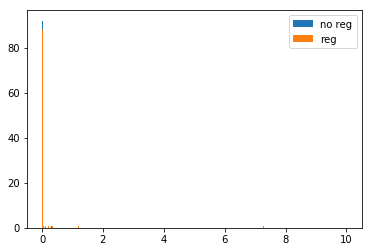

In [26]:
cov_reg = cca.calc_cov_from_cross_cov_mats(cross_cov_mats_reg)
w_reg, _ = np.linalg.eigh(cov_reg)

cov_no_reg = cca.calc_cov_from_cross_cov_mats(cross_cov_mats_no_reg)
w_no_reg, _ = np.linalg.eigh(cov_no_reg)

plt.hist(w_no_reg, bins=500, range=(0, 10), label="no reg")
plt.hist(w_reg, bins=500, range=(0, 10), label="reg")
plt.legend()

print(np.min(w_no_reg))

In [56]:
def stationarize(cov):
    cross_cov_mats = cca.calc_cross_cov_mats_from_cov(10, 5*2, cov)
    cov_stationary = cca.calc_cov_from_cross_cov_mats(cross_cov_mats)
    return cov_stationary

def psdize(cov):
    w, V = np.linalg.eigh(cov)
    w, V = w[::-1], V[:, ::-1]
    w = w - np.min(w) + 100
    cov_psd = np.dot(V, np.dot(np.diag(w), V.T))
    return cov_psd

def min_eig(cov):
    w, _ = np.linalg.eigh(cov)
    return np.min(w)
    
cov = np.copy(cov_no_reg)

In [57]:
#cov = psdize(cov)
print("eig:", min_eig(cov))

cov = stationarize(cov)

print("eig:", min_eig(cov))

cov = psdize(cov)

print("eig:", min_eig(cov))
print(np.max(np.abs(cov[10:20, 0:10] - cov[20:30, 10:20])))

cov = stationarize(cov)

print("eig:", min_eig(cov))
print(np.max(np.abs(cov[10:20, 0:10] - cov[20:30, 10:20])))


eig: -0.0004508111543175309
eig: -0.00045081115431683136
eig: 99.99999999999994
5.6288307348495437e-14
eig: 100.0
0.0


In [46]:
print(cov[10:20, 0:10] - cov[20:30, 10:20])

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

(499800, 10)


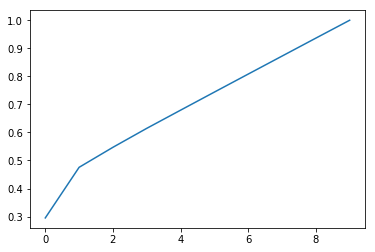

In [36]:
print(X.shape)
X_ctd = X - X.mean(axis=0)
cov = np.dot(X_ctd.T, X_ctd)/len(X_ctd)
w, _ = np.linalg.eigh(cov)
plt.plot(np.cumsum(w[::-1])/np.sum(w))